# VulnRAG-Hybrid System - Data Exploration of vulrag knowledge base
# 📊 Vulnerability Knowledge Base Analysis

## Overview
This notebook provides a comprehensive exploration of the VulRAG knowledge base, which contains information on security vulnerabilities categorized by CWE (Common Weakness Enumeration).

## Objectives
- Analyze the structure and content of the knowledge base
- Identify patterns and trends in vulnerability data
- Assess data quality and consistency
- Create a flat dataset for downstream analysis

## Data Structure
- **10 CWE categories** with their associated vulnerabilities
- **JSON format**: Each file contains CVEs with their instances
- **Hierarchy**: CWE → CVE → Vulnerability instances

---

# 1. Configuration and Environment Setup

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
from collections import defaultdict, Counter
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Environment configured successfully")

✅ Environment configured successfully


# 2. Path Configuration

In [2]:
# Set up paths
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
VULRAG_KB = DATA_RAW / 'vulrag_kb'
OUTPUT_PATH = PROJECT_ROOT / 'data' / 'processed' / 'kb1.json'

# Create results directory
results_dir = PROJECT_ROOT / 'results' / 'exploration'
metadata_file = results_dir / 'metadata.json'
results_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Project root: {PROJECT_ROOT}")
print(f"📁 VulRAG KB directory: {VULRAG_KB}")
print(f"📁 Results directory: {results_dir}")

📁 Project root: /Users/vernetemmanueladjobi/Documents/RessourcesStages/Projets/VulRAG-Hybrid-System
📁 VulRAG KB directory: /Users/vernetemmanueladjobi/Documents/RessourcesStages/Projets/VulRAG-Hybrid-System/data/raw/vulrag_kb
📁 Results directory: /Users/vernetemmanueladjobi/Documents/RessourcesStages/Projets/VulRAG-Hybrid-System/results/exploration


# 3. Data Availability Check

In [3]:
def check_data_availability():
    """Check if all required data files are available"""
    print("🔍 Checking VulRAG Knowledge Base availability...")
    
    if not VULRAG_KB.exists():
        print("❌ ERROR: VulRAG KB directory not found")
        print("Please run: ./download_data.sh")
        raise FileNotFoundError("VulRAG KB not available")
    
    kb_files = list(VULRAG_KB.glob("*.json"))
    print(f"✅ Found {len(kb_files)} KB files:")
    
    for file in sorted(kb_files):
        file_size = file.stat().st_size / 1024  # KB
        print(f"   📄 {file.name} ({file_size:.1f} KB)")
    
    return kb_files

# Execute availability check
kb_files = check_data_availability()
print(f"\n🎯 Ready to analyze {len(kb_files)} CWE knowledge bases")

🔍 Checking VulRAG Knowledge Base availability...
✅ Found 10 KB files:
   📄 gpt-4o-mini_CWE-119_316.json (1696.7 KB)
   📄 gpt-4o-mini_CWE-125_316.json (1503.3 KB)
   📄 gpt-4o-mini_CWE-200_316.json (1312.1 KB)
   📄 gpt-4o-mini_CWE-20_316.json (1759.1 KB)
   📄 gpt-4o-mini_CWE-264_316.json (1094.5 KB)
   📄 gpt-4o-mini_CWE-362_316.json (3007.8 KB)
   📄 gpt-4o-mini_CWE-401_316.json (831.1 KB)
   📄 gpt-4o-mini_CWE-416_316.json (5882.9 KB)
   📄 gpt-4o-mini_CWE-476_316.json (2621.1 KB)
   📄 gpt-4o-mini_CWE-787_316.json (2035.0 KB)

🎯 Ready to analyze 10 CWE knowledge bases


# 4. Data Loading Utilities

In [4]:
def load_single_kb_file(kb_file):
    """Load and process a single knowledge base file"""
    # Extract CWE from filename: gpt-4o-mini_CWE-119_316.json
    cwe = kb_file.stem.split('_')[1]  # CWE-119
    
    try:
        with open(kb_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Process the data - FIXED: Track CWE-CVE pairs, not just CVE
        cve_count = len(data)
        instance_count = sum(len(instances) for instances in data.values())
        
        # Store CWE-CVE pairs with instance counts
        cve_data = {}
        cwe_cve_pairs = {}
        
        for cve_id, instances in data.items():
            instance_count_for_cve = len(instances)
            cve_data[cve_id] = instance_count_for_cve
            
            # Create unique CWE-CVE pair identifier
            cwe_cve_key = f"{cwe}::{cve_id}"
            cwe_cve_pairs[cwe_cve_key] = {
                'cwe': cwe,
                'cve': cve_id,
                'instances': instance_count_for_cve
            }
        
        return {
            'cwe': cwe,
            'file': kb_file.name,
            'raw_data': data,
            'cve_count': cve_count,
            'instance_count': instance_count,
            'cve_data': cve_data,
            'cwe_cve_pairs': cwe_cve_pairs  # NEW: Track unique CWE-CVE combinations
        }
        
    except Exception as e:
        print(f"❌ ERROR loading {kb_file.name}: {e}")
        return None

def load_all_kb_files():
    """Load all knowledge base files"""
    print("📥 Loading all VulRAG knowledge base files...")
    
    kb_data = {}
    global_cve_registry = {}  # Track unique CVEs across all CWE
    global_cwe_cve_pairs = {}  # Track CWE-CVE combinations
    cwe_categories = set()
    
    for kb_file in sorted(VULRAG_KB.glob("*.json")):
        file_data = load_single_kb_file(kb_file)
        
        if file_data:
            cwe = file_data['cwe']
            cwe_categories.add(cwe)
            kb_data[cwe] = file_data
            
            # Build global CWE-CVE pair registry
            for cwe_cve_key, pair_info in file_data['cwe_cve_pairs'].items():
                global_cwe_cve_pairs[cwe_cve_key] = pair_info
            
            # Build global unique CVE registry
            for cve_id, instance_count in file_data['cve_data'].items():
                if cve_id not in global_cve_registry:
                    global_cve_registry[cve_id] = {
                        'unique_cve_id': cve_id,
                        'appears_in_cwes': [],
                        'total_instances_across_cwes': 0,
                        'cwe_breakdown': {}
                    }
                
                # Add this CWE to the CVE's record
                global_cve_registry[cve_id]['appears_in_cwes'].append(cwe)
                global_cve_registry[cve_id]['total_instances_across_cwes'] += instance_count
                global_cve_registry[cve_id]['cwe_breakdown'][cwe] = {
                    'instances': instance_count,
                    'file': file_data['file']
                }
    
    # Calculate corrected statistics
    unique_cves = len(global_cve_registry)
    total_cwe_cve_pairs = len(global_cwe_cve_pairs)
    total_instances = sum(pair['instances'] for pair in global_cwe_cve_pairs.values())
    
    # Identify cross-CWE CVEs
    cross_cwe_cves = {cve_id: info for cve_id, info in global_cve_registry.items() 
                      if len(info['appears_in_cwes']) > 1}
    
    kb_data['_summary'] = {
        'unique_cves': unique_cves,  # FIXED: Actual unique CVE count
        'total_cwe_cve_pairs': total_cwe_cve_pairs,  # NEW: CWE-CVE combinations
        'total_instances': total_instances,
        'total_cwe_categories': len(cwe_categories),
        'cross_cwe_cves': cross_cwe_cves,  # NEW: CVEs appearing in multiple CWE
        'cross_cwe_count': len(cross_cwe_cves),  # NEW: Count of cross-CWE CVEs
        'global_cve_registry': global_cve_registry,  # FIXED: Unique CVE data
        'global_cwe_cve_pairs': global_cwe_cve_pairs  # NEW: All CWE-CVE pairs
    }
    
    print(f"✅ Loaded {len(cwe_categories)} CWE categories")
    print(f"✅ Found {unique_cves} unique CVEs in {total_cwe_cve_pairs} CWE-CVE pairs")
    print(f"⚠️  {len(cross_cwe_cves)} CVEs appear in multiple CWE categories")
    
    return kb_data

# 5. Execute Data Loading

In [5]:
# Load all knowledge base data
vulrag_data = load_all_kb_files()

# Quick verification
summary = vulrag_data['_summary']
print("\n📊 LOADING SUMMARY:")
print(f"   🏷️  {summary['total_cwe_categories']} CWE categories")
print(f"   🔍 {summary['unique_cves']} unique CVEs")
print(f"   📝 {summary['total_instances']} function instances")

📥 Loading all VulRAG knowledge base files...
✅ Loaded 10 CWE categories
✅ Found 1154 unique CVEs in 1217 CWE-CVE pairs
⚠️  60 CVEs appear in multiple CWE categories

📊 LOADING SUMMARY:
   🏷️  10 CWE categories
   🔍 1154 unique CVEs
   📝 2317 function instances


# 6. Analysis Functions

In [6]:
def analyze_cwe_distribution(kb_data):
    """Analyze distribution across CWE categories"""
    cwe_stats = {}
    
    for cwe, info in kb_data.items():
        if cwe.startswith('_'):
            continue
            
        avg_instances = info['instance_count'] / info['cve_count'] if info['cve_count'] > 0 else 0
        
        cwe_stats[cwe] = {
            'cve_count': info['cve_count'],
            'instance_count': info['instance_count'],
            'avg_instances_per_cve': round(avg_instances, 2),
            'file': info['file']
        }
    
    return cwe_stats

def analyze_complexity_patterns(kb_data):
    """Analyze complexity patterns in the data (FIXED: maintains key compatibility)"""
    summary = kb_data['_summary']
    global_cwe_cve_pairs = summary['global_cwe_cve_pairs']
    global_cve_registry = summary['global_cve_registry']
    
    # Use CWE-CVE pairs for accurate instance distribution
    instance_counts_pairs = [pair['instances'] for pair in global_cwe_cve_pairs.values()]
    
    # Use unique CVEs for traditional metrics (maintain compatibility)
    unique_cve_complexities = [cve_info['total_instances_across_cwes'] 
                              for cve_info in global_cve_registry.values()]
    
    # MAINTAIN ORIGINAL KEYS for compatibility
    complexity_stats = {
        'avg_instances_per_cve': round(sum(unique_cve_complexities) / len(unique_cve_complexities), 2),
        'min_instances': min(unique_cve_complexities),
        'max_instances': max(unique_cve_complexities),
        'cves_with_multiple_instances': len([x for x in unique_cve_complexities if x > 1]),
        'high_complexity_cves': len([x for x in unique_cve_complexities if x > 3])
    }
    
    # Top complex CVEs (maintain original format)
    top_complex_unique_cves = sorted(
        [(cve_id, cve_info['total_instances_across_cwes'], cve_info['appears_in_cwes'][0]) 
         for cve_id, cve_info in global_cve_registry.items()],
        key=lambda x: x[1], reverse=True
    )[:10]
    
    complexity_stats['top_complex_cves'] = {
        cve: {'instances': instances, 'cwe': main_cwe} 
        for cve, instances, main_cwe in top_complex_unique_cves
    }
    
    # ADD NEW KEYS for cross-CWE analysis (without breaking existing code)
    complexity_stats.update({
        'avg_instances_per_cwe_cve_pair': round(sum(instance_counts_pairs) / len(instance_counts_pairs), 2),
        'total_cwe_cve_pairs': len(global_cwe_cve_pairs),
        'cwe_cve_pairs_with_multiple_instances': len([x for x in instance_counts_pairs if x > 1]),
        'high_complexity_pairs': len([x for x in instance_counts_pairs if x > 3]),
        'cross_cwe_metrics': {
            'unique_cves': len(global_cve_registry),
            'cross_cwe_count': len([cve for cve, info in global_cve_registry.items() 
                                   if len(info['appears_in_cwes']) > 1])
        }
    })
    
    return complexity_stats

def identify_data_patterns(cwe_stats, complexity_stats):
    """Identify interesting patterns in the data (FIXED: correct keys)"""
    patterns = {}
    
    # High volume CWEs
    high_volume_threshold = 100
    high_volume_cwes = [cwe for cwe, stats in cwe_stats.items() 
                       if stats['cve_count'] > high_volume_threshold]
    
    # High complexity CWEs
    high_complexity_threshold = 2.0
    high_complexity_cwes = [cwe for cwe, stats in cwe_stats.items() 
                           if stats['avg_instances_per_cve'] > high_complexity_threshold]
    
    # CWE dominance analysis - use CWE stats, not complexity stats
    total_cves_in_cwe_breakdown = sum(stats['cve_count'] for stats in cwe_stats.values())
    cwe_dominance = {cwe: (stats['cve_count'] / total_cves_in_cwe_breakdown) * 100 
                    for cwe, stats in cwe_stats.items()}
    
    dominant_cwe = max(cwe_dominance.items(), key=lambda x: x[1])
    
    patterns = {
        'high_volume_cwes': high_volume_cwes,
        'high_complexity_cwes': high_complexity_cwes,
        'dominant_cwe': {'cwe': dominant_cwe[0], 'percentage': round(dominant_cwe[1], 1)},
        'volume_complexity_overlap': list(set(high_volume_cwes) & set(high_complexity_cwes))
    }
    
    return patterns

# 7. Execute Analysis

In [7]:
# Perform comprehensive analysis
print("🔬 Analyzing CWE distribution...")
cwe_stats = analyze_cwe_distribution(vulrag_data)

print("🔬 Analyzing complexity patterns...")
complexity_stats = analyze_complexity_patterns(vulrag_data)

print("🔬 Identifying data patterns...")
data_patterns = identify_data_patterns(cwe_stats, complexity_stats)

print("✅ Analysis complete!")

🔬 Analyzing CWE distribution...
🔬 Analyzing complexity patterns...
🔬 Identifying data patterns...
✅ Analysis complete!


# 8. Display Functions

In [8]:
def display_global_overview(vulrag_data, complexity_stats):
    """Display high-level overview with CORRECTED statistics"""
    print("="*60)
    print(" 📊 GLOBAL OVERVIEW (CORRECTED)")
    print("="*60)
    
    summary = vulrag_data['_summary']
    
    print(f"🏷️  CWE Categories: {summary['total_cwe_categories']}")
    print(f"🔍 Unique CVEs: {summary['unique_cves']:,}")
    print(f"🔗 CWE-CVE Pairs: {summary['total_cwe_cve_pairs']:,}")
    print(f"📝 Total Instances: {summary['total_instances']:,}")
    print(f"📊 Average Instances/CVE: {complexity_stats['avg_instances_per_cve']}")
    print(f"🚨 High Complexity CVEs: {complexity_stats['high_complexity_cves']}")
    
    # NEW: Cross-CWE analysis
    cross_cwe_rate = (summary['cross_cwe_count'] / summary['unique_cves']) * 100
    print(f"\n⚠️  Cross-CWE Analysis:")
    print(f"   • CVEs in multiple CWE: {summary['cross_cwe_count']} ({cross_cwe_rate:.1f}%)")
    print(f"   • Average CWE per CVE: {summary['total_cwe_cve_pairs'] / summary['unique_cves']:.1f}")
    
    if summary['cross_cwe_cves']:
        # Find the CVE that appears in most CWE categories
        max_cross_cve = max(summary['cross_cwe_cves'].items(), 
                           key=lambda x: len(x[1]['appears_in_cwes']))
        cve_id, cve_info = max_cross_cve
        cwes = cve_info['appears_in_cwes']
        print(f"   • Most widespread CVE: {cve_id} (appears in {len(cwes)} CWE: {cwes})")

def display_cwe_breakdown(cwe_stats):
    """Display detailed CWE breakdown"""
    print("\n" + "="*60)
    print(" 🏷️  CWE CATEGORY BREAKDOWN")
    print("="*60)
    
    # Sort by CVE count
    sorted_cwes = sorted(cwe_stats.items(), key=lambda x: x[1]['cve_count'], reverse=True)
    
    print("\n📊 Top CWE Categories by Volume:")
    for i, (cwe, stats) in enumerate(sorted_cwes[:5], 1):
        print(f"   {i}. {cwe}: {stats['cve_count']} CVEs, {stats['instance_count']} instances")
        print(f"      Average: {stats['avg_instances_per_cve']} instances/CVE")
    
    # Sort by complexity
    sorted_by_complexity = sorted(cwe_stats.items(), 
                                 key=lambda x: x[1]['avg_instances_per_cve'], 
                                 reverse=True)
    
    print("\n🔥 Most Complex CWE Categories:")
    for i, (cwe, stats) in enumerate(sorted_by_complexity[:3], 1):
        print(f"   {i}. {cwe}: {stats['avg_instances_per_cve']} avg instances/CVE")
        print(f"      {stats['cve_count']} CVEs total")

def display_complexity_analysis(complexity_stats):
    """Display complexity analysis results (FIXED: correct keys)"""
    print("\n" + "="*60)
    print(" ⚡ COMPLEXITY ANALYSIS")
    print("="*60)
    
    print(f"📈 Instance Distribution:")
    print(f"   • Range: {complexity_stats['min_instances']}-{complexity_stats['max_instances']} instances per CVE")
    print(f"   • CVEs with multiple instances: {complexity_stats['cves_with_multiple_instances']}")
    print(f"   • High complexity CVEs (>3 instances): {complexity_stats['high_complexity_cves']}")
    
    # Cross-CWE metrics if available
    if 'cross_cwe_metrics' in complexity_stats:
        cross_metrics = complexity_stats['cross_cwe_metrics']
        print(f"   • Unique CVEs: {cross_metrics['unique_cves']}")
        print(f"   • Cross-CWE CVEs: {cross_metrics['cross_cwe_count']}")
    
    print(f"\n🚨 Most Complex CVEs:")
    for i, (cve, info) in enumerate(list(complexity_stats['top_complex_cves'].items())[:5], 1):
        print(f"   {i}. {cve}: {info['instances']} instances ({info['cwe']})")
    
    # Additional CWE-CVE pair metrics if available
    if 'avg_instances_per_cwe_cve_pair' in complexity_stats:
        print(f"\n📊 CWE-CVE Pair Analysis:")
        print(f"   • Total CWE-CVE pairs: {complexity_stats['total_cwe_cve_pairs']}")
        print(f"   • Average instances per pair: {complexity_stats['avg_instances_per_cwe_cve_pair']}")
        print(f"   • High complexity pairs: {complexity_stats['high_complexity_pairs']}")

def display_pattern_insights(data_patterns):
    """Display identified patterns and insights"""
    print("\n" + "="*60)
    print(" 🎯 PATTERN INSIGHTS")
    print("="*60)
    
    print(f"🏔️  High Volume CWEs (>100 CVEs): {data_patterns['high_volume_cwes']}")
    print(f"🔥 High Complexity CWEs (>2.0 avg): {data_patterns['high_complexity_cwes']}")
    print(f"⚖️  Volume+Complexity CWEs: {data_patterns['volume_complexity_overlap']}")
    
    dominant = data_patterns['dominant_cwe']
    print(f"\n👑 Dominant CWE: {dominant['cwe']} ({dominant['percentage']}% of all CVEs)")

# 9. Execute Display

In [9]:
# Display comprehensive analysis results
display_global_overview(vulrag_data, complexity_stats)
display_cwe_breakdown(cwe_stats)
display_complexity_analysis(complexity_stats)
display_pattern_insights(data_patterns)

 📊 GLOBAL OVERVIEW (CORRECTED)
🏷️  CWE Categories: 10
🔍 Unique CVEs: 1,154
🔗 CWE-CVE Pairs: 1,217
📝 Total Instances: 2,317
📊 Average Instances/CVE: 2.01
🚨 High Complexity CVEs: 122

⚠️  Cross-CWE Analysis:
   • CVEs in multiple CWE: 60 (5.2%)
   • Average CWE per CVE: 1.1
   • Most widespread CVE: CVE-2016-10200 (appears in 3 CWE: ['CWE-264', 'CWE-362', 'CWE-416'])

 🏷️  CWE CATEGORY BREAKDOWN

📊 Top CWE Categories by Volume:
   1. CWE-416: 300 CVEs, 660 instances
      Average: 2.2 instances/CVE
   2. CWE-476: 163 CVEs, 281 instances
      Average: 1.72 instances/CVE
   3. CWE-362: 159 CVEs, 320 instances
      Average: 2.01 instances/CVE
   4. CWE-119: 111 CVEs, 173 instances
      Average: 1.56 instances/CVE
   5. CWE-787: 107 CVEs, 187 instances
      Average: 1.75 instances/CVE

🔥 Most Complex CWE Categories:
   1. CWE-264: 2.93 avg instances/CVE
      41 CVEs total
   2. CWE-20: 2.3 avg instances/CVE
      79 CVEs total
   3. CWE-416: 2.2 avg instances/CVE
      300 CVEs total

 

# 10. Visualization Functions

In [10]:
def create_cwe_distribution_plot(cwe_stats):
    """Create CWE distribution visualization"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Prepare data
    cwes = list(cwe_stats.keys())
    cve_counts = [stats['cve_count'] for stats in cwe_stats.values()]
    complexity = [stats['avg_instances_per_cve'] for stats in cwe_stats.values()]
    
    # Plot 1: CVE count by CWE
    ax1.bar(cwes, cve_counts, color='skyblue', alpha=0.8)
    ax1.set_title('CVE Count by CWE Category', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of CVEs')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Plot 2: Complexity by CWE
    colors = ['red' if x > 2.5 else 'orange' if x > 2.0 else 'green' for x in complexity]
    ax2.bar(cwes, complexity, color=colors, alpha=0.8)
    ax2.set_title('Complexity by CWE Category', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Average Instances per CVE')
    ax2.tick_params(axis='x', rotation=45)
    ax2.axhline(y=2.0, color='red', linestyle='--', alpha=0.5, label='High Complexity Threshold')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_complexity_dashboard(complexity_stats, cwe_stats):
    """Create comprehensive complexity dashboard (FIXED: correct keys)"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Top CVEs pie chart
    top_cves = complexity_stats['top_complex_cves']
    top_5_cves = list(top_cves.items())[:5]
    cve_names = [cve.replace('CVE-', '') for cve, _ in top_5_cves]
    cve_instances = [info['instances'] for _, info in top_5_cves]
    
    ax1.pie(cve_instances, labels=cve_names, autopct='%1.0f', startangle=90)
    ax1.set_title('Top 5 Most Complex CVEs\n(by instance count)', fontweight='bold')
    
    # 2. Instance distribution histogram
    summary = vulrag_data['_summary']
    global_cve_registry = summary['global_cve_registry']
    instance_counts = [cve_info['total_instances_across_cwes'] for cve_info in global_cve_registry.values()]
    
    ax2.hist(instance_counts, bins=20, color='lightcoral', alpha=0.7, edgecolor='black')
    ax2.set_title('Instance Count Distribution', fontweight='bold')
    ax2.set_xlabel('Instances per CVE')
    ax2.set_ylabel('Frequency')
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Total instances by CWE
    cwes = list(cwe_stats.keys())
    instance_totals = [stats['instance_count'] for stats in cwe_stats.values()]
    
    ax3.bar(cwes, instance_totals, color='lightgreen', alpha=0.8)
    ax3.set_title('Total Instances by CWE', fontweight='bold')
    ax3.set_ylabel('Total Instances')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. CVE count vs Complexity scatter
    cve_counts = [stats['cve_count'] for stats in cwe_stats.values()]
    complexity = [stats['avg_instances_per_cve'] for stats in cwe_stats.values()]
    
    ax4.scatter(cve_counts, complexity, c='purple', alpha=0.6, s=100)
    ax4.set_title('CVE Volume vs Complexity', fontweight='bold')
    ax4.set_xlabel('Number of CVEs')
    ax4.set_ylabel('Average Instances per CVE')
    ax4.grid(alpha=0.3)
    
    # Add CWE labels to scatter plot
    for i, cwe in enumerate(cwes):
        ax4.annotate(cwe.replace('CWE-', ''), 
                    (cve_counts[i], complexity[i]), 
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=8, alpha=0.8)
    
    plt.tight_layout()
    plt.show()

# 11. Execute Visualizations

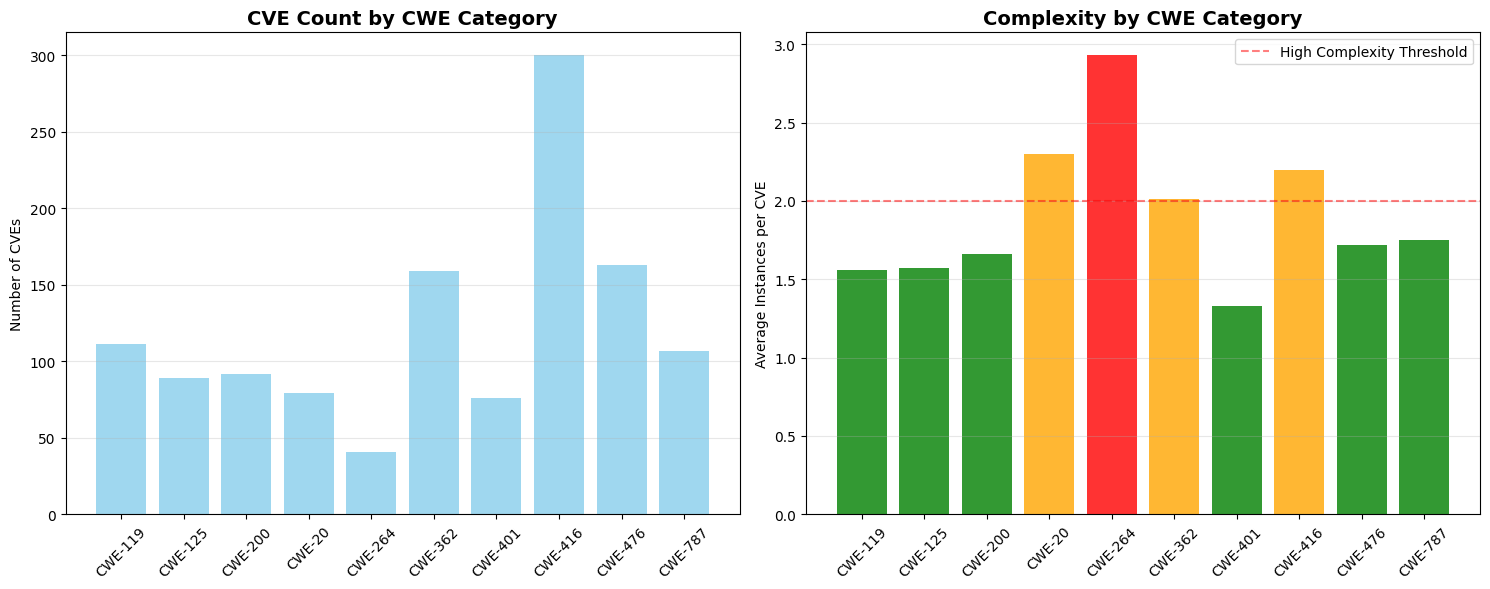

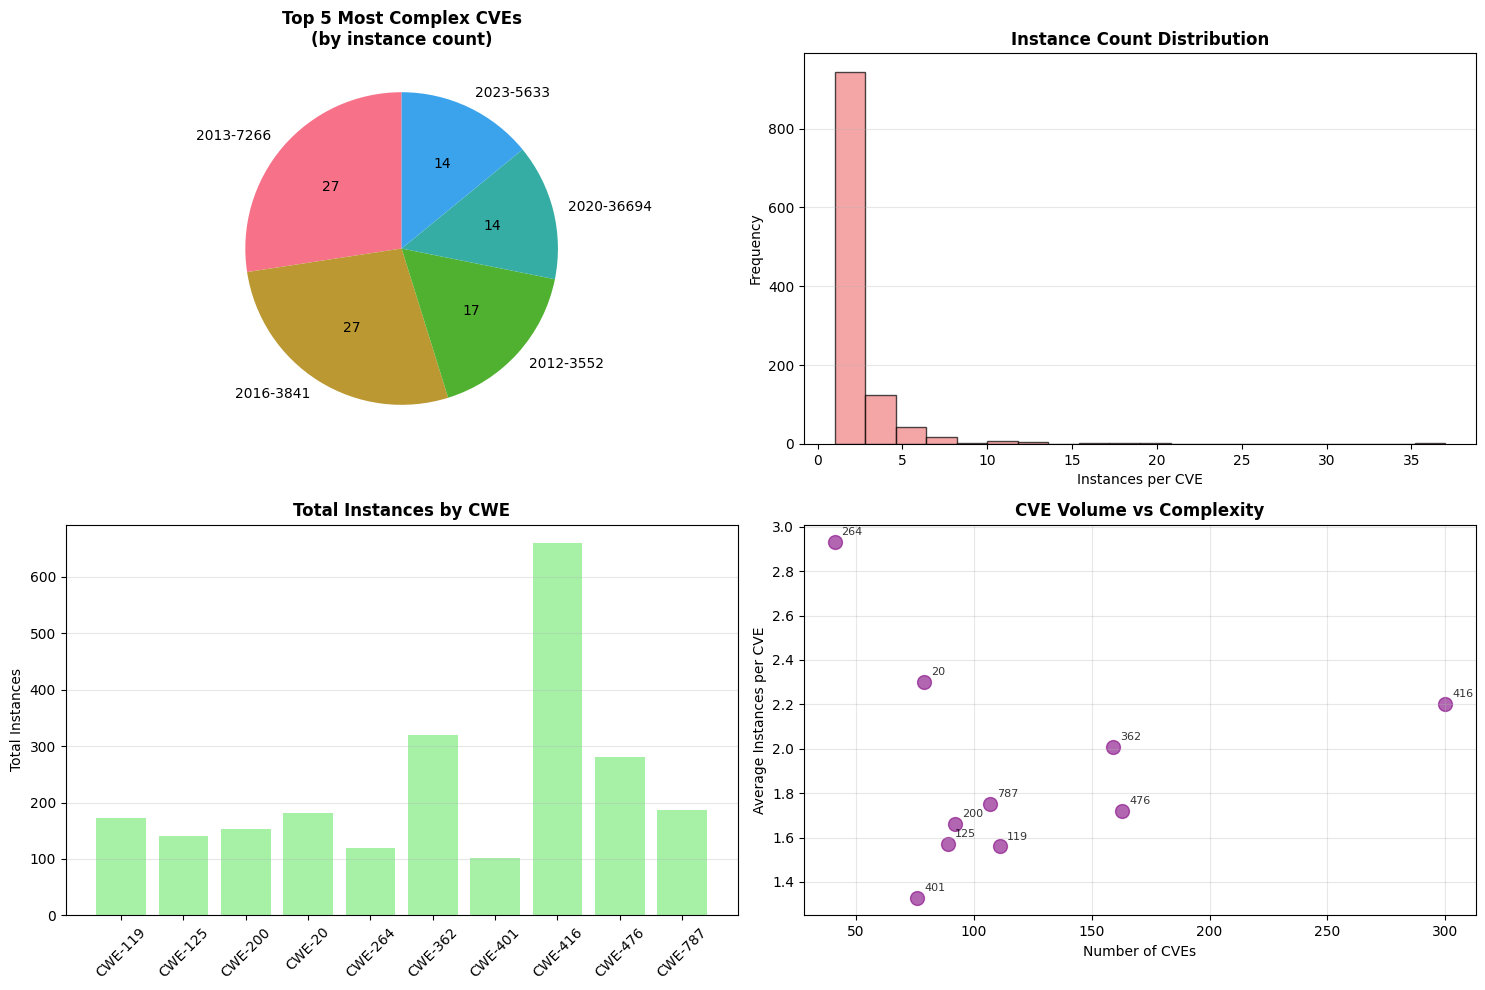

✅ Visualizations complete!


In [11]:
# Create CWE distribution plots
create_cwe_distribution_plot(cwe_stats)

# Create complexity dashboard
create_complexity_dashboard(complexity_stats, cwe_stats)

print("✅ Visualizations complete!")

# 12. Structure Validation - Field Consistency

In [12]:
def validate_field_consistency(kb_data):
    """Validate field consistency across all instances"""
    print("🔍 Validating field consistency...")
    
    expected_fields = set()
    validation_results = {
        'total_instances': 0,
        'field_inconsistencies': [],
        'missing_fields_by_cwe': {},
        'extra_fields_by_cwe': {}
    }
    
    # First pass: establish expected structure
    for cwe, info in kb_data.items():
        if cwe.startswith('_'):
            continue
            
        raw_data = info['raw_data']
        
        for cve_id, instances in raw_data.items():
            for instance_idx, instance in enumerate(instances):
                validation_results['total_instances'] += 1
                
                instance_fields = set(instance.keys())
                
                if not expected_fields:
                    expected_fields = instance_fields.copy()
                    print(f"✅ Reference structure from {cwe}:{cve_id}[{instance_idx}]")
                    print(f"   Expected fields ({len(expected_fields)}): {sorted(expected_fields)}")
                    break
            if expected_fields:
                break
        if expected_fields:
            break
    
    # Second pass: validate against expected structure
    for cwe, info in kb_data.items():
        if cwe.startswith('_'):
            continue
            
        missing_fields = set()
        extra_fields = set()
        raw_data = info['raw_data']
        
        for cve_id, instances in raw_data.items():
            for instance in instances:
                instance_fields = set(instance.keys())
                
                missing = expected_fields - instance_fields
                extra = instance_fields - expected_fields
                
                if missing:
                    missing_fields.update(missing)
                if extra:
                    extra_fields.update(extra)
        
        if missing_fields:
            validation_results['missing_fields_by_cwe'][cwe] = list(missing_fields)
        if extra_fields:
            validation_results['extra_fields_by_cwe'][cwe] = list(extra_fields)
    
    return validation_results, expected_fields

def validate_duplicated_fields(kb_data):
    """Validate duplicated fields content consistency"""
    print("🔍 Validating duplicated fields...")
    
    duplicated_fields = ['preconditions_for_vulnerability', 'trigger_condition', 
                        'specific_code_behavior_causing_vulnerability']
    
    validation_results = {
        'total_checked': 0,
        'duplication_errors': [],
        'errors_by_cwe': {}
    }
    
    for cwe, info in kb_data.items():
        if cwe.startswith('_'):
            continue
            
        cwe_errors = []
        raw_data = info['raw_data']
        
        for cve_id, instances in raw_data.items():
            for instance_idx, instance in enumerate(instances):
                validation_results['total_checked'] += 1
                
                for dup_field in duplicated_fields:
                    if dup_field in instance:
                        # Check if field exists in vulnerability_behavior
                        vb = instance.get('vulnerability_behavior', {})
                        if isinstance(vb, dict) and dup_field in vb:
                            root_value = instance[dup_field]
                            vb_value = vb[dup_field]
                            
                            if root_value != vb_value:
                                error = {
                                    'cve': cve_id,
                                    'instance': instance_idx,
                                    'field': dup_field,
                                    'error': 'Content mismatch'
                                }
                                cwe_errors.append(error)
                                validation_results['duplication_errors'].append(error)
        
        if cwe_errors:
            validation_results['errors_by_cwe'][cwe] = cwe_errors
    
    return validation_results

# 13. Execute Structure Validation

In [13]:
# Validate field consistency
field_validation, expected_fields = validate_field_consistency(vulrag_data)

# Validate duplicated fields
duplication_validation = validate_duplicated_fields(vulrag_data)

print("✅ Structure validation complete!")

🔍 Validating field consistency...
✅ Reference structure from CWE-119:CVE-2014-3182[0]
   Expected fields (12): ['CVE_id', 'GPT_analysis', 'GPT_function', 'GPT_purpose', 'code_after_change', 'code_before_change', 'modified_lines', 'preconditions_for_vulnerability', 'solution', 'specific_code_behavior_causing_vulnerability', 'trigger_condition', 'vulnerability_behavior']
🔍 Validating duplicated fields...
✅ Structure validation complete!


# 14. Display Validation Results

In [14]:
def display_validation_results(field_validation, duplication_validation):
    """Display comprehensive validation results"""
    print("="*60)
    print(" 🔍 STRUCTURE VALIDATION RESULTS")
    print("="*60)
    
    # Field consistency results
    print(f"📊 Field Consistency:")
    print(f"   • Total instances validated: {field_validation['total_instances']:,}")
    
    if field_validation['missing_fields_by_cwe']:
        print(f"   • CWEs with missing fields: {len(field_validation['missing_fields_by_cwe'])}")
        for cwe, missing in list(field_validation['missing_fields_by_cwe'].items())[:3]:
            print(f"     - {cwe}: {missing}")
    else:
        print("   ✅ All CWEs have required fields")
    
    if field_validation['extra_fields_by_cwe']:
        print(f"   • CWEs with extra fields: {len(field_validation['extra_fields_by_cwe'])}")
        for cwe, extra in list(field_validation['extra_fields_by_cwe'].items())[:3]:
            print(f"     - {cwe}: {extra}")
    else:
        print("   ✅ No unexpected extra fields found")
    
    # Duplication validation results
    print(f"\n🔄 Duplication Validation:")
    print(f"   • Total instances checked: {duplication_validation['total_checked']:,}")
    print(f"   • Duplication errors found: {len(duplication_validation['duplication_errors'])}")
    
    if duplication_validation['errors_by_cwe']:
        print(f"   • CWEs with duplication issues: {len(duplication_validation['errors_by_cwe'])}")
        for cwe, errors in list(duplication_validation['errors_by_cwe'].items())[:3]:
            print(f"     - {cwe}: {len(errors)} errors")
    else:
        print("   ✅ All duplicated fields are consistent")
    
    # Overall status
    has_field_issues = bool(field_validation['missing_fields_by_cwe'] or 
                           field_validation['extra_fields_by_cwe'])
    has_duplication_issues = bool(duplication_validation['duplication_errors'])
    
    overall_status = "❌ ISSUES FOUND" if (has_field_issues or has_duplication_issues) else "✅ ALL VALID"
    print(f"\n🎯 Overall Status: {overall_status}")

# Execute validation display
display_validation_results(field_validation, duplication_validation)

 🔍 STRUCTURE VALIDATION RESULTS
📊 Field Consistency:
   • Total instances validated: 1
   ✅ All CWEs have required fields
   ✅ No unexpected extra fields found

🔄 Duplication Validation:
   • Total instances checked: 2,317
   • Duplication errors found: 0
   ✅ All duplicated fields are consistent

🎯 Overall Status: ✅ ALL VALID


# 15. Save Analysis Results

In [15]:
def save_analysis_results(vulrag_data, cwe_stats, complexity_stats, data_patterns):
    """Save comprehensive analysis results (FIXED: correct keys)"""
    print("💾 Saving analysis results...")
    
    # Create comprehensive report
    analysis_report = {
        "metadata": {
            "analysis_date": datetime.now().isoformat(),
            "total_cwe_categories": vulrag_data['_summary']['total_cwe_categories'],
            "unique_cves": vulrag_data['_summary']['unique_cves'],
            "total_cwe_cve_pairs": vulrag_data['_summary']['total_cwe_cve_pairs'],
            "total_instances": vulrag_data['_summary']['total_instances'],
            "cross_cwe_count": vulrag_data['_summary']['cross_cwe_count']
        },
        "cwe_breakdown": cwe_stats,
        "complexity_analysis": complexity_stats,
        "data_patterns": data_patterns,
        "global_cve_registry": vulrag_data['_summary']['global_cve_registry'],
        "cross_cwe_cves": vulrag_data['_summary']['cross_cwe_cves']
    }
    
    # Save complete analysis
    complete_file = results_dir / "vulrag_complete_analysis.json"
    with open(complete_file, 'w', encoding='utf-8') as f:
        json.dump(analysis_report, f, indent=2, ensure_ascii=False)
    
    # Save summary report (maintain compatibility)
    summary_report = {
        "analysis_metadata": analysis_report["metadata"],
        "cwe_breakdown": cwe_stats,
        "top_cves_by_instances": complexity_stats["top_complex_cves"],
        "statistics": {
            "avg_instances_per_cve": complexity_stats["avg_instances_per_cve"],
            "min_instances": complexity_stats["min_instances"],
            "max_instances": complexity_stats["max_instances"],
            "cves_with_multiple_instances": complexity_stats["cves_with_multiple_instances"]
        }
    }
    
    summary_file = results_dir / "vulrag_summary_report.json"
    with open(summary_file, 'w', encoding='utf-8') as f:
        json.dump(summary_report, f, indent=2, ensure_ascii=False)
    
    print(f"✅ Complete analysis saved: {complete_file}")
    print(f"✅ Summary report saved: {summary_file}")
    
    return complete_file, summary_file

# Save all analysis results
complete_file, summary_file = save_analysis_results(vulrag_data, cwe_stats, complexity_stats, data_patterns)

💾 Saving analysis results...
✅ Complete analysis saved: /Users/vernetemmanueladjobi/Documents/RessourcesStages/Projets/VulRAG-Hybrid-System/results/exploration/vulrag_complete_analysis.json
✅ Summary report saved: /Users/vernetemmanueladjobi/Documents/RessourcesStages/Projets/VulRAG-Hybrid-System/results/exploration/vulrag_summary_report.json


# 16. Code Extraction - Functions

In [16]:
def extract_code_to_files(vulrag_kb_dir, output_dir):
    """Extract code instances from VulRAG KB to separate files"""
    print("🔄 Extracting code files from VulRAG KB...")
    
    # Create output structure
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True, parents=True)
    
    # Global metadata
    metadata = {
        'extraction_info': {
            'timestamp': str(pd.Timestamp.now()),
            'source_directory': str(vulrag_kb_dir),
            'output_directory': str(output_path)
        },
        'statistics': {
            'total_files_processed': 0,
            'total_instances': 0,
            'total_code_files_created': 0,
            'empty_code_instances': 0,
            'by_cwe': {}
        },
        'file_mappings': {},
        'instance_mappings': {}
    }
    
    global_instance_counter = 0
    
    return metadata, output_path, global_instance_counter

def process_cwe_file(kb_file, output_path, metadata, global_instance_counter):
    """Process a single CWE knowledge base file"""
    cwe = kb_file.stem.split('_')[1]  # Extract CWE-XXX
    
    print(f"   📄 Processing {kb_file.name}...")
    
    # Create CWE directory
    cwe_dir = output_path / cwe
    cwe_dir.mkdir(exist_ok=True)
    
    with open(kb_file, 'r', encoding='utf-8') as f:
        cwe_data = json.load(f)
    
    cwe_stats = {
        'source_file': kb_file.name,
        'cve_count': len(cwe_data.keys()),
        'instance_count': 0,
        'code_files_created': 0,
        'empty_code_instances': 0,
        'instances': {}
    }
    
    # Process each CVE in this CWE
    for cve_id, instances in cwe_data.items():
        cve_instances = []
        
        for idx, instance in enumerate(instances):
            global_instance_counter += 1
            cwe_stats['instance_count'] += 1
            
            # Extract and process code
            vuln_code = instance.get('code_before_change', '').strip()
            patch_code = instance.get('code_after_change', '').strip()
            
            # Handle empty code instances
            is_empty = not vuln_code or not patch_code
            if is_empty:
                cwe_stats['empty_code_instances'] += 1
                metadata['statistics']['empty_code_instances'] += 1
                if not vuln_code:
                    vuln_code = "// Empty vulnerable code"
                if not patch_code:
                    patch_code = "// Empty patched code"
            
            # Create and write files
            instance_metadata = create_code_files(
                cwe, cwe_dir, cve_id, idx, vuln_code, patch_code, 
                instance, kb_file.name, is_empty, global_instance_counter
            )
            
            cve_instances.append(instance_metadata)
            cwe_stats['code_files_created'] += 2
            
            # Update global mappings
            update_metadata_mappings(metadata, instance_metadata, cwe)
        
        if cve_instances:
            cwe_stats['instances'][cve_id] = cve_instances
    
    return cwe_stats, global_instance_counter

def create_code_files(cwe, cwe_dir, cve_id, idx, vuln_code, patch_code, 
                     instance, source_file, is_empty, global_counter):
    """Create individual code files and return metadata (FIXED: unique filenames)"""
    # FIXED: Include CWE in filename to avoid conflicts across CWE categories
    base_name = f"{cwe}_{cve_id}_{idx}"  # e.g., CWE-119_CVE-2014-3182_0
    vuln_filename = f"{base_name}_vuln.c"
    patch_filename = f"{base_name}_patch.c"
    
    vuln_filepath = cwe_dir / vuln_filename
    patch_filepath = cwe_dir / patch_filename
    
    # Write files
    with open(vuln_filepath, 'w', encoding='utf-8') as f:
        f.write(vuln_code)
    
    with open(patch_filepath, 'w', encoding='utf-8') as f:
        f.write(patch_code)
    
    # Create instance metadata with UNIQUE identifiers
    instance_metadata = {
        'instance_id': f"{cwe}_{cve_id}_{idx}",  # FIXED: Include CWE for uniqueness
        'cve_id': cve_id,
        'cwe': cwe,
        'instance_index': idx,
        'global_counter': global_counter,
        'source_file': source_file,
        'has_empty_code': is_empty,
        'files': {
            'vulnerable_code': {
                'filename': vuln_filename,
                'full_path': str(vuln_filepath),
                'relative_path': f"{cwe}/{vuln_filename}",
                'size_bytes': len(vuln_code.encode('utf-8')),
                'line_count': len(vuln_code.split('\n'))
            },
            'patched_code': {
                'filename': patch_filename,
                'full_path': str(patch_filepath),
                'relative_path': f"{cwe}/{patch_filename}",
                'size_bytes': len(patch_code.encode('utf-8')),
                'line_count': len(patch_code.split('\n'))
            }
        },
        'additional_info': {
            'vulnerability_type': instance.get('preconditions_for_vulnerability', ''),
            'trigger_condition': instance.get('trigger_condition', ''),
            'solution': instance.get('solution', ''),
            'gpt_purpose': instance.get('GPT_purpose', ''),
            'modified_lines': instance.get('modified_lines', {})
        }
    }
    
    return instance_metadata

def update_metadata_mappings(metadata, instance_metadata, cwe):
    """Update global metadata mappings"""
    instance_id = instance_metadata['instance_id']
    vuln_filename = instance_metadata['files']['vulnerable_code']['filename']
    patch_filename = instance_metadata['files']['patched_code']['filename']
    
    # Use unique keys for file mappings
    unique_vuln_key = f"{cwe}_{vuln_filename}"
    unique_patch_key = f"{cwe}_{patch_filename}"
    
    metadata['file_mappings'][unique_vuln_key] = instance_metadata
    metadata['file_mappings'][unique_patch_key] = instance_metadata
    metadata['instance_mappings'][instance_id] = instance_metadata

# 17. Execute Code Extraction

In [17]:
def run_code_extraction():
    """Execute the complete code extraction pipeline"""
    print("🚀 Starting code extraction pipeline...")
    
    # Setup paths
    output_dir = PROJECT_ROOT / "data" / "tmp" / "temp_code_files"
    
    # Initialize extraction
    metadata, output_path, global_counter = extract_code_to_files(VULRAG_KB, output_dir)
    
    # Process each CWE file
    for kb_file in sorted(VULRAG_KB.glob("*.json")):
        cwe_stats, global_counter = process_cwe_file(
            kb_file, output_path, metadata, global_counter
        )
        
        # Update global statistics
        metadata['statistics']['by_cwe'][cwe_stats['source_file'].split('_')[1]] = cwe_stats
        metadata['statistics']['total_files_processed'] += 1
        metadata['statistics']['total_instances'] += cwe_stats['instance_count']
        metadata['statistics']['total_code_files_created'] += cwe_stats['code_files_created']
        
        print(f"      ✅ {cwe_stats['code_files_created']} files from {cwe_stats['instance_count']} instances")
    
    # Save metadata
    
    with open(metadata_file, 'w', encoding='utf-8') as f:
        json.dump(metadata, f, indent=2, ensure_ascii=False)
    
    return metadata, output_path, metadata_file

# Execute code extraction
print("📁 Executing code extraction...")
extraction_metadata, code_output_path, metadata_file = run_code_extraction()

# Display results
print(f"\n✅ Code extraction completed!")
print(f"   📁 Output directory: {code_output_path}")
print(f"   📊 Files processed: {extraction_metadata['statistics']['total_files_processed']}")
print(f"   📝 Total instances: {extraction_metadata['statistics']['total_instances']}")
print(f"   💾 Code files created: {extraction_metadata['statistics']['total_code_files_created']}")
print(f"   ⚠️  Empty instances: {extraction_metadata['statistics']['empty_code_instances']}")
print(f"   📋 Metadata saved: {metadata_file}")

📁 Executing code extraction...
🚀 Starting code extraction pipeline...
🔄 Extracting code files from VulRAG KB...
   📄 Processing gpt-4o-mini_CWE-119_316.json...
      ✅ 346 files from 173 instances
   📄 Processing gpt-4o-mini_CWE-125_316.json...
      ✅ 280 files from 140 instances
   📄 Processing gpt-4o-mini_CWE-200_316.json...
      ✅ 306 files from 153 instances
   📄 Processing gpt-4o-mini_CWE-20_316.json...
      ✅ 364 files from 182 instances
   📄 Processing gpt-4o-mini_CWE-264_316.json...
      ✅ 240 files from 120 instances
   📄 Processing gpt-4o-mini_CWE-362_316.json...
      ✅ 640 files from 320 instances
   📄 Processing gpt-4o-mini_CWE-401_316.json...
      ✅ 202 files from 101 instances
   📄 Processing gpt-4o-mini_CWE-416_316.json...
      ✅ 1320 files from 660 instances
   📄 Processing gpt-4o-mini_CWE-476_316.json...
      ✅ 562 files from 281 instances
   📄 Processing gpt-4o-mini_CWE-787_316.json...
      ✅ 374 files from 187 instances

✅ Code extraction completed!
   📁 Out

# 18. Code Extraction Analysis

In [18]:
def analyze_code_extraction(metadata):
    """Analyze the results of code extraction"""
    print("📊 Analyzing code extraction results...")
    
    stats = metadata['statistics']
    by_cwe = stats['by_cwe']
    
    # Calculate rates
    empty_rate = (stats['empty_code_instances'] / stats['total_instances']) * 100 if stats['total_instances'] > 0 else 0
    avg_files_per_cwe = stats['total_code_files_created'] / len(by_cwe) if by_cwe else 0
    
    print(f"\n📈 Extraction Statistics:")
    print(f"   • Empty code rate: {empty_rate:.1f}%")
    print(f"   • Average files per CWE: {avg_files_per_cwe:.0f}")
    
    # CWE breakdown
    print(f"\n🏷️  Extraction by CWE:")
    for cwe, cwe_data in sorted(by_cwe.items()):
        print(f"   {cwe}: {cwe_data['instance_count']} instances → {cwe_data['code_files_created']} files")
        if cwe_data['empty_code_instances'] > 0:
            print(f"      ⚠️  {cwe_data['empty_code_instances']} empty instances")
    
    # File size analysis
    file_mappings = metadata['file_mappings']
    sizes = []
    line_counts = []
    
    for mapping in file_mappings.values():
        if 'files' in mapping:
            for file_type, file_info in mapping['files'].items():
                sizes.append(file_info['size_bytes'])
                line_counts.append(file_info['line_count'])
    
    if sizes:
        print(f"\n📏 File Statistics:")
        print(f"   • Average file size: {sum(sizes)/len(sizes):.0f} bytes")
        print(f"   • Average line count: {sum(line_counts)/len(line_counts):.0f} lines")
        print(f"   • Max file size: {max(sizes)} bytes")
        print(f"   • Max line count: {max(line_counts)} lines")

# Execute extraction analysis
analyze_code_extraction(extraction_metadata)

📊 Analyzing code extraction results...

📈 Extraction Statistics:
   • Empty code rate: 0.0%
   • Average files per CWE: 463

🏷️  Extraction by CWE:
   CWE-119: 173 instances → 346 files
   CWE-125: 140 instances → 280 files
   CWE-20: 182 instances → 364 files
   CWE-200: 153 instances → 306 files
   CWE-264: 120 instances → 240 files
   CWE-362: 320 instances → 640 files
   CWE-401: 101 instances → 202 files
   CWE-416: 660 instances → 1320 files
   CWE-476: 281 instances → 562 files
   CWE-787: 187 instances → 374 files

📏 File Statistics:
   • Average file size: 1809 bytes
   • Average line count: 69 lines
   • Max file size: 35052 bytes
   • Max line count: 1481 lines


# 19. Change Classification - Functions

In [19]:
import re
import difflib
from dataclasses import dataclass
from typing import List, Tuple, Optional

# C/C++ file extensions
CODE_EXTENSIONS = {".c", ".h", ".cpp", ".cc", ".hpp"}

@dataclass
class ChangeClassification:
    cwe: Optional[str]
    rel_dir: str
    vuln_file: str
    patch_file: str
    classification: str  # no_change | whitespace_only | comment_only | code_change
    lines_vuln: int
    lines_patch: int
    code_diff_sample: Optional[str] = None

def read_file_safely(file_path):
    """Read file with multiple encoding attempts"""
    for encoding in ("utf-8", "latin-1", "cp1252"):
        try:
            return file_path.read_text(encoding=encoding)
        except Exception:
            continue
    # Last resort
    return file_path.read_bytes().decode(errors="ignore")

def normalize_whitespace(text):
    """Normalize whitespace for comparison"""
    return re.sub(r"\s+", " ", text).strip()

def strip_comments_preserve_structure(code):
    """Remove C/C++ comments while preserving string literals and line structure"""
    i, n = 0, len(code)
    output = []
    state = 'normal'
    
    while i < n:
        ch = code[i]
        next_ch = code[i + 1] if i + 1 < n else ""
        
        if state == 'normal':
            if ch == '"' and (i == 0 or code[i-1] != "\\"):
                state = 'string'
                output.append(ch)
            elif ch == "'" and (i == 0 or code[i-1] != "\\"):
                state = 'char'
                output.append(ch)
            elif ch == "/" and next_ch == "/":
                state = 'line_comment'
                i += 1  # Skip the second /
            elif ch == "/" and next_ch == "*":
                state = 'block_comment'
                i += 1  # Skip the *
            else:
                output.append(ch)
        
        elif state == 'string':
            output.append(ch)
            if ch == '"' and code[i-1] != "\\":
                state = 'normal'
        
        elif state == 'char':
            output.append(ch)
            if ch == "'" and code[i-1] != "\\":
                state = 'normal'
        
        elif state == 'line_comment':
            if ch == "\n":
                output.append("\n")  # Preserve line structure
                state = 'normal'
        
        elif state == 'block_comment':
            if ch == "\n":
                output.append("\n")  # Preserve line structure
            if ch == "*" and next_ch == "/":
                state = 'normal'
                i += 1  # Skip the /
        
        i += 1
    
    return "".join(output)

def classify_code_change(vuln_text, patch_text):
    """Classify the type of change between vulnerable and patched code"""
    # No change
    if vuln_text == patch_text:
        return "no_change"
    
    # Whitespace only change
    if normalize_whitespace(vuln_text) == normalize_whitespace(patch_text):
        return "whitespace_only"
    
    # Remove comments and check again
    vuln_no_comments = strip_comments_preserve_structure(vuln_text)
    patch_no_comments = strip_comments_preserve_structure(patch_text)
    
    # Comment only change
    if normalize_whitespace(vuln_no_comments) == normalize_whitespace(patch_no_comments):
        return "comment_only"
    
    # Code change
    return "code_change"

def create_code_diff(vuln_text, patch_text, vuln_filename, patch_filename, context_lines=3):
    """Create a unified diff of code changes"""
    vuln_no_comments = strip_comments_preserve_structure(vuln_text)
    patch_no_comments = strip_comments_preserve_structure(patch_text)
    
    diff = list(difflib.unified_diff(
        vuln_no_comments.splitlines(keepends=True),
        patch_no_comments.splitlines(keepends=True),
        fromfile=f"{vuln_filename} (no-comments)",
        tofile=f"{patch_filename} (no-comments)",
        n=context_lines
    ))
    
    diff_text = "".join(diff)
    
    # Truncate if too long
    if len(diff_text) > 8000:
        diff_text = diff_text[:8000] + "\n... [truncated] ...\n"
    
    return diff_text

def find_code_pairs(root_path):
    """Find all vuln/patch file pairs in the extracted code directory"""
    pairs = []
    
    for vuln_path in root_path.rglob("*_vuln.*"):
        if vuln_path.suffix.lower() not in CODE_EXTENSIONS:
            continue
        
        patch_path = Path(str(vuln_path).replace("_vuln.", "_patch."))
        if patch_path.exists():
            pairs.append((vuln_path, patch_path))
    
    return pairs

# 20. Execute Change Classification

In [20]:
def run_change_classification(code_directory, show_diffs=True, max_examples=10):
    """Execute change classification on extracted code files"""
    print("🔍 Running change classification analysis...")
    
    root_path = Path(code_directory)
    pairs = find_code_pairs(root_path)
    
    print(f"   📁 Found {len(pairs)} vuln/patch pairs to analyze")
    
    # Classification results
    results = []
    stats = {"total": 0, "no_change": 0, "whitespace_only": 0, "comment_only": 0, "code_change": 0}
    
    # Process each pair
    for vuln_path, patch_path in pairs:
        # Read files
        vuln_text = read_file_safely(vuln_path)
        patch_text = read_file_safely(patch_path)
        
        # Classify change
        classification = classify_code_change(vuln_text, patch_text)
        
        # Create diff sample for code changes
        code_diff = None
        if show_diffs and classification == "code_change":
            code_diff = create_code_diff(vuln_text, patch_text, vuln_path.name, patch_path.name)
        
        # Extract CWE from path
        rel_dir = str(vuln_path.parent.relative_to(root_path))
        cwe = None
        for part in rel_dir.split("/"):
            if part.startswith("CWE-"):
                cwe = part
                break
        
        # Create result
        result = ChangeClassification(
            cwe=cwe,
            rel_dir=rel_dir,
            vuln_file=vuln_path.name,
            patch_file=patch_path.name,
            classification=classification,
            lines_vuln=vuln_text.count("\n") + 1,
            lines_patch=patch_text.count("\n") + 1,
            code_diff_sample=code_diff
        )
        
        results.append(result)
        stats["total"] += 1
        stats[classification] += 1
    
    return results, stats

# Execute classification
classification_results, classification_stats = run_change_classification(
    code_output_path, show_diffs=True, max_examples=20
)

print(f"✅ Classification completed!")
print(f"   📊 Analyzed {classification_stats['total']} pairs")

🔍 Running change classification analysis...
   📁 Found 2317 vuln/patch pairs to analyze
✅ Classification completed!
   📊 Analyzed 2317 pairs


# 21. Change Classification Analysis & Results

In [21]:
def display_classification_results(results, stats):
    """Display comprehensive classification analysis"""
    print("="*60)
    print(" 🔍 CHANGE CLASSIFICATION RESULTS")
    print("="*60)
    
    # Overall statistics
    total = stats['total']
    print(f"📊 Classification Summary:")
    print(f"   • Total pairs analyzed: {total}")
    
    for category in ['no_change', 'whitespace_only', 'comment_only', 'code_change']:
        count = stats[category]
        percentage = (count / total * 100) if total > 0 else 0
        print(f"   • {category.replace('_', ' ').title()}: {count} ({percentage:.1f}%)")
    
    # CWE breakdown
    cwe_breakdown = defaultdict(lambda: defaultdict(int))
    for result in results:
        if result.cwe:
            cwe_breakdown[result.cwe][result.classification] += 1
    
    print(f"\n🏷️  Classification by CWE:")
    for cwe in sorted(cwe_breakdown.keys()):
        cwe_stats = cwe_breakdown[cwe]
        total_cwe = sum(cwe_stats.values())
        code_changes = cwe_stats['code_change']
        code_change_rate = (code_changes / total_cwe * 100) if total_cwe > 0 else 0
        
        print(f"   {cwe}: {total_cwe} pairs, {code_changes} code changes ({code_change_rate:.1f}%)")
    
    # Examples by category
    print(f"\n📋 Examples by Category:")
    for category in ['code_change', 'comment_only', 'whitespace_only', 'no_change']:
        category_results = [r for r in results if r.classification == category]
        if not category_results:
            continue
        
        print(f"\n-- {category.replace('_', ' ').title()} ({len(category_results)}) --")
        
        # Show a few examples
        for i, result in enumerate(category_results[:3]):
            print(f"   [{result.cwe or 'CWE-?'}] {result.vuln_file} → {result.patch_file}")
            print(f"      Lines: {result.lines_vuln} → {result.lines_patch}")
            
            # Show diff for code changes
            if category == 'code_change' and result.code_diff_sample and i == 0:
                print(f"      Code diff sample:")
                # Show only first few lines of diff
                diff_lines = result.code_diff_sample.split('\n')[:10]
                for line in diff_lines:
                    if line.strip():
                        print(f"         {line}")
                if len(result.code_diff_sample.split('\n')) > 10:
                    print(f"         ... (truncated)")

def save_classification_results(results, stats, output_path):
    """Save classification results to JSON"""
    # Convert dataclass results to dictionaries
    results_dict = []
    for result in results:
        result_dict = {
            'cwe': result.cwe,
            'rel_dir': result.rel_dir,
            'vuln_file': result.vuln_file,
            'patch_file': result.patch_file,
            'classification': result.classification,
            'lines_vuln': result.lines_vuln,
            'lines_patch': result.lines_patch
            # Note: excluding code_diff_sample for JSON size
        }
        results_dict.append(result_dict)
    
    # Create output data
    output_data = {
        'classification_metadata': {
            'analysis_date': datetime.now().isoformat(),
            'total_pairs': stats['total']
        },
        'statistics': stats,
        'results': results_dict
    }
    
    # Save to file
    classification_file = output_path / "classification_results.json"
    with open(classification_file, 'w', encoding='utf-8') as f:
        json.dump(output_data, f, indent=2, ensure_ascii=False)
    
    print(f"💾 Classification results saved: {classification_file}")
    return classification_file

# Display and save results
display_classification_results(classification_results, classification_stats)
classification_file = save_classification_results(classification_results, classification_stats, results_dir)

 🔍 CHANGE CLASSIFICATION RESULTS
📊 Classification Summary:
   • Total pairs analyzed: 2317
   • No Change: 0 (0.0%)
   • Whitespace Only: 2 (0.1%)
   • Comment Only: 12 (0.5%)
   • Code Change: 2303 (99.4%)

🏷️  Classification by CWE:
   CWE-119: 173 pairs, 171 code changes (98.8%)
   CWE-125: 140 pairs, 140 code changes (100.0%)
   CWE-20: 182 pairs, 181 code changes (99.5%)
   CWE-200: 153 pairs, 151 code changes (98.7%)
   CWE-264: 120 pairs, 119 code changes (99.2%)
   CWE-362: 320 pairs, 315 code changes (98.4%)
   CWE-401: 101 pairs, 101 code changes (100.0%)
   CWE-416: 660 pairs, 659 code changes (99.8%)
   CWE-476: 281 pairs, 279 code changes (99.3%)
   CWE-787: 187 pairs, 187 code changes (100.0%)

📋 Examples by Category:

-- Code Change (2303) --
   [CWE-264] CWE-264_CVE-2012-2313_0_vuln.c → CWE-264_CVE-2012-2313_0_patch.c
      Lines: 59 → 25
      Code diff sample:
         --- CWE-264_CVE-2012-2313_0_vuln.c (no-comments)
         +++ CWE-264_CVE-2012-2313_0_patch.c (no-co

# 22. Flat Dataset Creation - Data Extraction

In [22]:
def load_metadata():
    """Load the metadata.json file"""
    print("📥 Loading metadata.json...")
    
    if not metadata_file.exists():
        raise FileNotFoundError(f"Metadata file not found: {metadata_file}")
    
    with open(metadata_file, 'r', encoding='utf-8') as f:
        metadata = json.load(f)
    
    print(f"✅ Metadata loaded successfully")
    return metadata

def extract_vulrag_fields(vulrag_entry):
    """Extract VulRAG data fields without nesting"""
    if not vulrag_entry:
        return {}
    
    extracted = {}
    
    # Direct fields
    direct_fields = ['solution', 'GPT_analysis', 'GPT_purpose', 'GPT_function', 
                    'CVE_id', 'code_before_change', 'code_after_change', 'modified_lines']
    
    for field in direct_fields:
        if field in vulrag_entry:
            extracted[field] = vulrag_entry[field]
    
    # Handle nested vulnerability_behavior
    if 'vulnerability_behavior' in vulrag_entry:
        vb = vulrag_entry['vulnerability_behavior']
        if isinstance(vb, dict):
            # Extract nested fields
            nested_fields = ['preconditions_for_vulnerability', 'trigger_condition', 
                           'specific_code_behavior_causing_vulnerability']
            for field in nested_fields:
                if field in vb:
                    extracted[field] = vb[field]
            
            # Extract the main vulnerability_behavior if it's a string
            if 'vulnerability_behavior' in vb:
                extracted['vulnerability_behavior'] = vb['vulnerability_behavior']
        else:
            # If it's already a string, use it directly
            extracted['vulnerability_behavior'] = vb
    
    return extracted

def match_vulrag_instance(vulrag_instances, instance_index):
    """Match VulRAG instance based on index"""
    if vulrag_instances and instance_index < len(vulrag_instances):
        return vulrag_instances[instance_index]
    return None

# 23. Flat Dataset Creation - Processing

In [23]:
def create_flat_dataset():
    """Create a flat VulRAG dataset with essential data only"""
    print("🔄 Creating flat VulRAG dataset...")
    
    # Load required data
    metadata = load_metadata()
    
    # Extract metadata statistics
    statistics = metadata.get('statistics', {})
    by_cwe = statistics.get('by_cwe', {})
    
    print(f"📊 Metadata contains {statistics.get('total_instances', 0)} instances")
    print(f"📊 Processing {len(by_cwe)} CWE categories...")
    
    flat_dataset = {}
    counters = {
        'processed': 0,
        'matched': 0,
        'vulrag_found': 0
    }
    
    # Process each CWE category
    for cwe_id, cwe_data in by_cwe.items():
        print(f"\n🔄 Processing {cwe_id}...")
        
        # Get VulRAG data for this CWE
        vulrag_cwe_data = vulrag_data.get(cwe_id, {}).get('raw_data', {})
        
        # Process instances
        instances = cwe_data.get('instances', {})
        
        for cve_id, cve_instances in instances.items():
            vulrag_instances = vulrag_cwe_data.get(cve_id, [])
            
            for instance_data in cve_instances:
                instance_id = instance_data.get('instance_id', '')
                composite_key = f"{cwe_id}_{instance_id}"
                
                # Extract metadata
                files = instance_data.get('files', {})
                vuln_file = files.get('vulnerable_code', {})
                patch_file = files.get('patched_code', {})
                additional_info = instance_data.get('additional_info', {})
                
                # Match VulRAG instance
                instance_index = instance_data.get('instance_index', 0)
                vulrag_entry = match_vulrag_instance(vulrag_instances, instance_index)
                
                # Extract VulRAG fields
                vulrag_fields = extract_vulrag_fields(vulrag_entry)
                
                # Create flat entry
                flat_entry = {
                    'cwe_id': cwe_id,
                    'cve_id': cve_id,
                    'instance_id': instance_id,
                    'vuln_line_count': vuln_file.get('line_count', 0),
                    'patch_line_count': patch_file.get('line_count', 0),
                    'vulnerability_type': additional_info.get('vulnerability_type', ''),
                    'trigger_condition': additional_info.get('trigger_condition', ''),
                    'solution': additional_info.get('solution', ''),
                    'gpt_purpose': additional_info.get('gpt_purpose', ''),
                    'modified_lines': additional_info.get('modified_lines', {})
                }
                
                # Add VulRAG fields
                flat_entry.update(vulrag_fields)
                
                # Store in dataset
                flat_dataset[composite_key] = flat_entry
                
                # Update counters
                counters['processed'] += 1
                if vulrag_entry:
                    counters['matched'] += 1
                    if any(vulrag_fields.values()):
                        counters['vulrag_found'] += 1
    
    print(f"\n✅ Processing complete!")
    print(f"   📝 Total entries: {counters['processed']}")
    print(f"   🔗 VulRAG matches: {counters['matched']}")
    print(f"   📋 With VulRAG data: {counters['vulrag_found']}")
    
    if counters['processed'] > 0:
        match_rate = (counters['matched'] / counters['processed']) * 100
        data_rate = (counters['vulrag_found'] / counters['processed']) * 100
        print(f"   📊 Match rate: {match_rate:.1f}%")
        print(f"   📊 Data coverage: {data_rate:.1f}%")
    
    return flat_dataset, counters

# Execute flat dataset creation
flat_dataset, processing_counters = create_flat_dataset()

🔄 Creating flat VulRAG dataset...
📥 Loading metadata.json...
✅ Metadata loaded successfully
📊 Metadata contains 2317 instances
📊 Processing 10 CWE categories...

🔄 Processing CWE-119...

🔄 Processing CWE-125...

🔄 Processing CWE-200...

🔄 Processing CWE-20...

🔄 Processing CWE-264...

🔄 Processing CWE-362...

🔄 Processing CWE-401...

🔄 Processing CWE-416...

🔄 Processing CWE-476...

🔄 Processing CWE-787...

✅ Processing complete!
   📝 Total entries: 2317
   🔗 VulRAG matches: 2317
   📋 With VulRAG data: 2317
   📊 Match rate: 100.0%
   📊 Data coverage: 100.0%


# 24. Flat Dataset Analysis & Export

In [24]:
def analyze_flat_dataset(flat_dataset):
    """Analyze the created flat dataset"""
    print("📊 Analyzing flat dataset...")
    
    if not flat_dataset:
        print("❌ No data to analyze")
        return {}
    
    # Basic statistics
    total_entries = len(flat_dataset)
    
    # Distribution analysis
    cwe_dist = defaultdict(int)
    cve_dist = defaultdict(int)
    
    # Field completeness
    field_completeness = defaultdict(int)
    
    # Numeric statistics
    vuln_lines = []
    patch_lines = []
    
    for entry in flat_dataset.values():
        # Distributions
        cwe_dist[entry['cwe_id']] += 1
        cve_dist[entry['cve_id']] += 1
        
        # Field completeness
        for field, value in entry.items():
            if value and value != '' and value != {}:
                field_completeness[field] += 1
        
        # Numeric data
        if entry['vuln_line_count'] > 0:
            vuln_lines.append(entry['vuln_line_count'])
        if entry['patch_line_count'] > 0:
            patch_lines.append(entry['patch_line_count'])
    
    # Calculate statistics
    analysis_results = {
        'total_entries': total_entries,
        'cwe_distribution': dict(cwe_dist),
        'top_cves': dict(sorted(cve_dist.items(), key=lambda x: x[1], reverse=True)[:10]),
        'field_completeness': {field: (count/total_entries)*100 
                              for field, count in field_completeness.items()},
        'line_statistics': {
            'avg_vuln_lines': sum(vuln_lines)/len(vuln_lines) if vuln_lines else 0,
            'avg_patch_lines': sum(patch_lines)/len(patch_lines) if patch_lines else 0,
            'max_vuln_lines': max(vuln_lines) if vuln_lines else 0,
            'max_patch_lines': max(patch_lines) if patch_lines else 0
        }
    }
    
    return analysis_results

def display_flat_dataset_analysis(analysis_results):
    """Display flat dataset analysis results"""
    print("="*60)
    print(" 📊 FLAT DATASET ANALYSIS")
    print("="*60)
    
    print(f"📝 Total entries: {analysis_results['total_entries']:,}")
    
    # CWE distribution
    print(f"\n🏷️  CWE Distribution:")
    for cwe, count in sorted(analysis_results['cwe_distribution'].items()):
        percentage = (count / analysis_results['total_entries']) * 100
        print(f"   {cwe}: {count:,} entries ({percentage:.1f}%)")
    
    # Top CVEs
    print(f"\n🔍 Top CVEs by Instance Count:")
    for i, (cve, count) in enumerate(list(analysis_results['top_cves'].items())[:5], 1):
        print(f"   {i}. {cve}: {count} instances")
    
    # Field completeness
    print(f"\n📋 Field Completeness:")
    important_fields = ['vulnerability_behavior', 'solution', 'GPT_analysis', 'trigger_condition']
    for field in important_fields:
        if field in analysis_results['field_completeness']:
            percentage = analysis_results['field_completeness'][field]
            print(f"   {field}: {percentage:.1f}% complete")
    
    # Line statistics
    line_stats = analysis_results['line_statistics']
    print(f"\n📏 Code Line Statistics:")
    print(f"   Average vulnerable lines: {line_stats['avg_vuln_lines']:.0f}")
    print(f"   Average patch lines: {line_stats['avg_patch_lines']:.0f}")
    print(f"   Max vulnerable lines: {line_stats['max_vuln_lines']}")
    print(f"   Max patch lines: {line_stats['max_patch_lines']}")

def export_flat_dataset(flat_dataset, analysis_results):
    """Export flat dataset and analysis"""
    print("💾 Exporting flat dataset...")
    
    # Save flat dataset
    OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
    
    with open(OUTPUT_PATH, 'w', encoding='utf-8') as f:
        json.dump(flat_dataset, f, indent=2, ensure_ascii=False)
    
    file_size_mb = OUTPUT_PATH.stat().st_size / (1024*1024)
    
    # Save analysis
    analysis_file = results_dir / "flat_dataset_analysis.json"
    with open(analysis_file, 'w', encoding='utf-8') as f:
        json.dump(analysis_results, f, indent=2, ensure_ascii=False)
    
    print(f"✅ Flat dataset saved: {OUTPUT_PATH} ({file_size_mb:.1f} MB)")
    print(f"✅ Analysis saved: {analysis_file}")
    
    return OUTPUT_PATH, analysis_file

# Execute flat dataset analysis
dataset_analysis = analyze_flat_dataset(flat_dataset)
display_flat_dataset_analysis(dataset_analysis)

# Export results
dataset_file, analysis_file = export_flat_dataset(flat_dataset, dataset_analysis)

📊 Analyzing flat dataset...
 📊 FLAT DATASET ANALYSIS
📝 Total entries: 2,317

🏷️  CWE Distribution:
   CWE-119: 173 entries (7.5%)
   CWE-125: 140 entries (6.0%)
   CWE-20: 182 entries (7.9%)
   CWE-200: 153 entries (6.6%)
   CWE-264: 120 entries (5.2%)
   CWE-362: 320 entries (13.8%)
   CWE-401: 101 entries (4.4%)
   CWE-416: 660 entries (28.5%)
   CWE-476: 281 entries (12.1%)
   CWE-787: 187 entries (8.1%)

🔍 Top CVEs by Instance Count:
   1. CVE-2013-7266: 37 instances
   2. CVE-2016-3841: 37 instances
   3. CVE-2012-3552: 23 instances
   4. CVE-2020-36694: 19 instances
   5. CVE-2023-5633: 19 instances

📋 Field Completeness:
   solution: 100.0% complete
   GPT_analysis: 100.0% complete
   trigger_condition: 100.0% complete

📏 Code Line Statistics:
   Average vulnerable lines: 68
   Average patch lines: 70
   Max vulnerable lines: 1479
   Max patch lines: 1481
💾 Exporting flat dataset...
✅ Flat dataset saved: /Users/vernetemmanueladjobi/Documents/RessourcesStages/Projets/VulRAG-Hybri

# 25. Cross-CWE Analysis

In [25]:
def analyze_cross_cwe_patterns(vulrag_data, flat_dataset):
    """Analyze patterns in CVEs that appear across multiple CWE categories"""
    print("🔍 Analyzing Cross-CWE patterns...")
    
    summary = vulrag_data['_summary']
    cross_cwe_cves = summary['cross_cwe_cves']
    
    if not cross_cwe_cves:
        print("✅ No cross-CWE CVEs detected")
        return {}
    
    # Analysis of cross-CWE patterns
    analysis = {
        'total_cross_cwe_cves': len(cross_cwe_cves),
        'max_cwe_per_cve': max(len(info['appears_in_cwes']) for info in cross_cwe_cves.values()),
        'cwe_combination_patterns': defaultdict(int),
        'impact_analysis': {}
    }
    
    # Analyze CWE combination patterns
    for cve_id, cve_info in cross_cwe_cves.items():
        cwes = sorted(cve_info['appears_in_cwes'])
        combination = '+'.join(cwes)
        analysis['cwe_combination_patterns'][combination] += 1
    
    # Impact analysis: How do solutions differ across CWE for same CVE?
    solution_differences = {}
    for cve_id, cve_info in cross_cwe_cves.items():
        cve_solutions = {}
        
        # Find all instances of this CVE in flat dataset
        cve_instances = {k: v for k, v in flat_dataset.items() if v['cve_id'] == cve_id}
        
        for instance_key, instance_data in cve_instances.items():
            cwe = instance_data['cwe_id']
            solution = instance_data.get('solution', '')
            if solution:
                cve_solutions[cwe] = solution
        
        # Check if solutions are different across CWE
        if len(set(cve_solutions.values())) > 1:
            solution_differences[cve_id] = cve_solutions
    
    analysis['solution_differences'] = solution_differences
    
    return analysis

def display_cross_cwe_analysis(cross_cwe_analysis):
    """Display cross-CWE analysis results"""
    if not cross_cwe_analysis:
        return
    
    print("="*60)
    print(" ⚠️  CROSS-CWE ANALYSIS")
    print("="*60)
    
    print(f"📊 Cross-CWE Statistics:")
    print(f"   • CVEs in multiple CWE: {cross_cwe_analysis['total_cross_cwe_cves']}")
    print(f"   • Max CWE per CVE: {cross_cwe_analysis['max_cwe_per_cve']}")
    
    # Most common CWE combinations
    patterns = cross_cwe_analysis['cwe_combination_patterns']
    print(f"\n🔗 Most Common CWE Combinations:")
    for combination, count in sorted(patterns.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"   • {combination}: {count} CVEs")
    
    # Solution differences
    solution_diffs = cross_cwe_analysis['solution_differences']
    if solution_diffs:
        print(f"\n🚨 CVEs with Different Solutions Across CWE:")
        print(f"   Found {len(solution_diffs)} CVEs with varying solutions")
        
        for cve_id, solutions in list(solution_diffs.items())[:3]:
            print(f"\n   {cve_id}:")
            for cwe, solution in solutions.items():
                short_solution = solution[:100] + "..." if len(solution) > 100 else solution
                print(f"      {cwe}: {short_solution}")
    else:
        print(f"\n✅ All cross-CWE CVEs have consistent solutions")

def recommendations_for_cross_cwe(cross_cwe_analysis, dataset_analysis):
    """Generate recommendations for handling cross-CWE CVEs"""
    print("\n" + "="*60)
    print(" 💡 RECOMMENDATIONS FOR CROSS-CWE HANDLING")
    print("="*60)
    
    total_entries = dataset_analysis['total_entries']
    cross_cwe_count = cross_cwe_analysis.get('total_cross_cwe_cves', 0)
    
    if cross_cwe_count == 0:
        print("✅ No cross-CWE issues detected - current approach is fine")
        return
    
    cross_cwe_rate = (cross_cwe_count / total_entries) * 100
    
    print(f"🎯 Impact Assessment:")
    print(f"   • {cross_cwe_rate:.1f}% of dataset affected by cross-CWE CVEs")
    
    if cross_cwe_rate > 10:
        print(f"   🚨 HIGH IMPACT: Cross-CWE affects significant portion of data")
    elif cross_cwe_rate > 5:
        print(f"   ⚠️  MEDIUM IMPACT: Cross-CWE affects notable portion of data")
    else:
        print(f"   ✅ LOW IMPACT: Cross-CWE affects small portion of data")
    
    print(f"\n📋 Recommendations:")
    
    if cross_cwe_rate > 5:
        print("   1. 🔍 Analysis: Always specify CWE context in analyses")
        print("   2. 📊 Metrics: Report 'unique CVEs' vs 'CWE-CVE pairs' separately")
        print("   3. 🏷️  Labeling: Use CWE-prefixed identifiers (e.g., CWE-119_CVE-2014-3182)")
        print("   4. 📈 ML Models: Consider CWE as feature to distinguish contexts")
    
    solution_diffs = cross_cwe_analysis.get('solution_differences', {})
    if solution_diffs:
        print("   5. 🚨 CRITICAL: Some CVEs have different solutions per CWE")
        print("      → Review solution consistency manually")
        print("      → Consider CWE-specific solution paths")
    
    max_cwe_per_cve = cross_cwe_analysis.get('max_cwe_per_cve', 1)
    if max_cwe_per_cve > 3:
        print(f"   6. 🔄 Data Quality: Some CVEs appear in {max_cwe_per_cve} CWE - validate categorization")

# Execute cross-CWE analysis
cross_cwe_analysis = analyze_cross_cwe_patterns(vulrag_data, flat_dataset)
display_cross_cwe_analysis(cross_cwe_analysis)
recommendations_for_cross_cwe(cross_cwe_analysis, dataset_analysis)

🔍 Analyzing Cross-CWE patterns...
 ⚠️  CROSS-CWE ANALYSIS
📊 Cross-CWE Statistics:
   • CVEs in multiple CWE: 60
   • Max CWE per CVE: 3

🔗 Most Common CWE Combinations:
   • CWE-362+CWE-416: 30 CVEs
   • CWE-416+CWE-787: 5 CVEs
   • CWE-125+CWE-787: 4 CVEs
   • CWE-416+CWE-476: 3 CVEs
   • CWE-119+CWE-264: 2 CVEs

🚨 CVEs with Different Solutions Across CWE:
   Found 60 CVEs with varying solutions

   CVE-2016-8632:
      CWE-119: To mitigate the vulnerability, it is necessary to add checks that validate the maximum allowable pac...
      CWE-264: To mitigate the vulnerability, it is necessary to validate the MTU before assigning it to the networ...

   CVE-2018-7566:
      CWE-119: To mitigate the vulnerability, it is necessary to protect access to shared resources with appropriat...
      CWE-362: To mitigate the vulnerability, it is essential to wrap the resource pool initialization in a mutex l...

   CVE-2016-6187:
      CWE-119: To mitigate the vulnerability, it is necessary to al

# 26. Final Summary & Sample Data

In [26]:
def display_final_summary():
    """Display comprehensive final summary"""
    print("="*60)
    print(" 🎯 FINAL ANALYSIS SUMMARY")
    print("="*60)
    
    # Knowledge base summary
    summary = vulrag_data['_summary']
    print(f"📚 Knowledge Base:")
    print(f"   • {summary['total_cwe_categories']} CWE categories")
    print(f"   • {summary['unique_cves']:,} unique CVEs")
    print(f"   • {summary['total_instances']:,} vulnerability instances")
    
    # Analysis highlights
    dominant_cwe = data_patterns['dominant_cwe']
    print(f"\n🔍 Key Insights:")
    print(f"   • Dominant CWE: {dominant_cwe['cwe']} ({dominant_cwe['percentage']}%)")
    print(f"   • High complexity CVEs: {complexity_stats['high_complexity_cves']}")
    print(f"   • Average instances per CVE: {complexity_stats['avg_instances_per_cve']}")
    
    # Flat dataset summary
    print(f"\n📊 Flat Dataset:")
    print(f"   • Total entries: {len(flat_dataset):,}")
    print(f"   • VulRAG matches: {processing_counters['matched']:,}")
    print(f"   • Data coverage: {(processing_counters['vulrag_found']/processing_counters['processed']*100):.1f}%")
    
    # Files created
    print(f"\n📁 Generated Files:")
    print(f"   • Complete analysis: {complete_file.name}")
    print(f"   • Summary report: {summary_file.name}")
    print(f"   • Flat dataset: {dataset_file.name}")
    print(f"   • Dataset analysis: {analysis_file.name}")

def show_sample_data():
    """Show sample entries from the flat dataset"""
    if not flat_dataset:
        print("❌ No sample data available")
        return
    
    print(f"\n📋 Sample Flat Dataset Entry:")
    print("="*40)
    
    # Get a sample entry
    sample_key = list(flat_dataset.keys())[0]
    sample_entry = flat_dataset[sample_key]
    
    print(f"🔑 Key: {sample_key}")
    print(f"📝 Entry structure:")
    
    # Display key fields only
    key_fields = ['cwe_id', 'cve_id', 'vuln_line_count', 'patch_line_count', 
                 'vulnerability_type', 'solution', 'GPT_purpose']
    
    for field in key_fields:
        if field in sample_entry:
            value = sample_entry[field]
            # Truncate long strings
            if isinstance(value, str) and len(value) > 100:
                value = value[:100] + "..."
            print(f"   {field}: {value}")
    
    print(f"\n📊 Total fields in entry: {len(sample_entry)}")

# Display final summary
display_final_summary()
show_sample_data()

 🎯 FINAL ANALYSIS SUMMARY
📚 Knowledge Base:
   • 10 CWE categories
   • 1,154 unique CVEs
   • 2,317 vulnerability instances

🔍 Key Insights:
   • Dominant CWE: CWE-416 (24.7%)
   • High complexity CVEs: 122
   • Average instances per CVE: 2.01

📊 Flat Dataset:
   • Total entries: 2,317
   • VulRAG matches: 2,317
   • Data coverage: 100.0%

📁 Generated Files:
   • Complete analysis: vulrag_complete_analysis.json
   • Summary report: vulrag_summary_report.json
   • Flat dataset: kb1.json
   • Dataset analysis: flat_dataset_analysis.json

📋 Sample Flat Dataset Entry:
🔑 Key: CWE-119_CWE-119_CVE-2014-3182_0
📝 Entry structure:
   cwe_id: CWE-119
   cve_id: CVE-2014-3182
   vuln_line_count: 88
   patch_line_count: 81
   vulnerability_type: Invalid user input provided to the device index, which is not properly validated before use.
   solution: To mitigate the vulnerability, it is essential to validate the device index before it is used to acc...
   GPT_purpose: "The function `logi_dj_recv_ad

# 27. Final Complete Summary

In [27]:
def display_complete_summary():
    """Display comprehensive final summary of all analyses"""
    print("="*60)
    print(" 🎯 COMPLETE ANALYSIS SUMMARY")
    print("="*60)
    
    # Knowledge base analysis
    summary = vulrag_data['_summary']
    print(f"📚 Knowledge Base Analysis:")
    print(f"   • {summary['total_cwe_categories']} CWE categories")
    print(f"   • {summary['unique_cves']:,} unique CVEs")
    print(f"   • {summary['total_instances']:,} vulnerability instances")
    
    # Key insights
    dominant_cwe = data_patterns['dominant_cwe']
    print(f"\n🔍 Key Insights:")
    print(f"   • Dominant CWE: {dominant_cwe['cwe']} ({dominant_cwe['percentage']}%)")
    print(f"   • High complexity CVEs: {complexity_stats['high_complexity_cves']}")
    print(f"   • Average instances per CVE: {complexity_stats['avg_instances_per_cve']}")
    
    # Flat dataset
    print(f"\n📊 Flat Dataset:")
    print(f"   • Total entries: {len(flat_dataset):,}")
    print(f"   • VulRAG matches: {processing_counters['matched']:,}")
    print(f"   • Data coverage: {(processing_counters['vulrag_found']/processing_counters['processed']*100):.1f}%")
    
    # Code extraction
    extract_stats = extraction_metadata['statistics']
    print(f"\n💾 Code Extraction:")
    print(f"   • Code files created: {extract_stats['total_code_files_created']:,}")
    print(f"   • Empty instances: {extract_stats['empty_code_instances']}")
    print(f"   • Output directory: {code_output_path.name}")
    
    # Change classification
    code_changes = classification_stats['code_change']
    total_pairs = classification_stats['total']
    change_rate = (code_changes / total_pairs * 100) if total_pairs > 0 else 0
    print(f"\n🔍 Change Classification:")
    print(f"   • Total pairs analyzed: {total_pairs}")
    print(f"   • Actual code changes: {code_changes} ({change_rate:.1f}%)")
    print(f"   • Comment/whitespace only: {classification_stats['comment_only'] + classification_stats['whitespace_only']}")
    
    # Generated files
    print(f"\n📁 Generated Files:")
    print(f"   • Complete analysis: {complete_file.name}")
    print(f"   • Summary report: {summary_file.name}")
    print(f"   • Flat dataset: {dataset_file.name}")
    print(f"   • Code extraction metadata: {metadata_file.name}")
    print(f"   • Classification results: {classification_file.name}")
    
    print(f"\n🎯 Analysis Quality Metrics:")
    match_rate = (processing_counters['matched'] / processing_counters['processed'] * 100)
    print(f"   • VulRAG match rate: {match_rate:.1f}%")
    empty_rate = (extract_stats['empty_code_instances'] / extract_stats['total_instances'] * 100)
    print(f"   • Empty code rate: {empty_rate:.1f}%")
    print(f"   • Real code changes: {change_rate:.1f}%")

# Display complete summary
display_complete_summary()

print("\n🎉 VulRAG Knowledge Base Analysis Complete!")
print("Full pipeline: Analysis → Code Extraction → Change Classification → Flat Dataset")
print("All data has been processed, analyzed, and exported successfully.")

 🎯 COMPLETE ANALYSIS SUMMARY
📚 Knowledge Base Analysis:
   • 10 CWE categories
   • 1,154 unique CVEs
   • 2,317 vulnerability instances

🔍 Key Insights:
   • Dominant CWE: CWE-416 (24.7%)
   • High complexity CVEs: 122
   • Average instances per CVE: 2.01

📊 Flat Dataset:
   • Total entries: 2,317
   • VulRAG matches: 2,317
   • Data coverage: 100.0%

💾 Code Extraction:
   • Code files created: 4,634
   • Empty instances: 0
   • Output directory: temp_code_files

🔍 Change Classification:
   • Total pairs analyzed: 2317
   • Actual code changes: 2303 (99.4%)
   • Comment/whitespace only: 14

📁 Generated Files:
   • Complete analysis: vulrag_complete_analysis.json
   • Summary report: vulrag_summary_report.json
   • Flat dataset: kb1.json
   • Code extraction metadata: metadata.json
   • Classification results: classification_results.json

🎯 Analysis Quality Metrics:
   • VulRAG match rate: 100.0%
   • Empty code rate: 0.0%
   • Real code changes: 99.4%

🎉 VulRAG Knowledge Base Analysis